In [70]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

class Household(Agent):
    def __init__(self, unique_id, model, disposable_income, dwelling, inability=False):
        super().__init__(unique_id, model)
        self.disposable_income = disposable_income
        self.dwelling = dwelling
        self.inability = inability
        self.savings = 0  # savings is initialized as 0

    @property
    def energy_cost(self):
        """Calculate and return the current energy cost for the agent."""
        return self.model.energy_price * (self.dwelling)

    def step(self):
        """Update the agent's savings in a step."""
        self.savings += self.disposable_income - self.energy_cost
        self.inability = self.energy_cost > self.disposable_income * 0.1


class Country(Model):
    
    @classmethod
    def calculate_gini(cls, incomes):
        incomes = np.sort(incomes)
        n = len(incomes)
        index = np.arange(1, n + 1)
        return ((np.sum((2 * index - n  - 1) * incomes)) / (n * np.sum(incomes)))

    @classmethod
    def generate_income_distribution(cls, num_people, median_income, gini_target, lower_bound):
        alpha = (gini_target + 1) / (2 - gini_target)
        for _ in range(10000):
            incomes = stats.gamma.rvs(alpha, scale=median_income/alpha, size=num_people)
            incomes = np.clip(incomes, lower_bound, None)  # None means there is no upper bound
            gini_current = cls.calculate_gini(incomes)
            if np.isclose(gini_current, gini_target, atol=0.01):
                return incomes
            elif gini_current < gini_target:
                alpha *= 0.9
            else:
                alpha *= 1.1

        raise Exception(f"Failed to reach target Gini coefficient in 1000 iterations. Current Gini: {gini_current}")
    
    @staticmethod
    def assign_inability(agents, inability_start):
        """
        Assigns the inability to the agents.
        """
        agents.sort(key=lambda x: x.disposable_income)

        num_agents = len(agents)
        num_unable = int(inability_start * num_agents)
        inability_per_quintile = np.array([2, 1.6, 1.2, 0.8, 0])
        inability_per_quintile *= num_unable / np.sum(inability_per_quintile)
        inability_per_quintile = inability_per_quintile.astype(int)

        assigned_unable = 0
        for i in range(5):  # For each quintile
            start = i * num_agents // 5
            end = (i + 1) * num_agents // 5 if i < 4 else num_agents
            quintile = agents[start:end]
            num_unable_quintile = min(inability_per_quintile[i], len(quintile))
            unable_agents = np.random.choice(quintile, num_unable_quintile, replace=False)
            for agent in unable_agents:
                agent.inability = True
            assigned_unable += num_unable_quintile

        # Assign remaining inability if any
        i = 0
        while assigned_unable < num_unable:
            start = i * num_agents // 5
            end = (i + 1) * num_agents // 5 if i < 4 else num_agents
            quintile = [agent for agent in agents[start:end] if not agent.inability]
            if quintile:
                agent = np.random.choice(quintile)
                agent.inability = True
                assigned_unable += 1
            else:
                i += 1


    @staticmethod
    def assign_dwelling(agents, energy_price):
        """
        Assigns the dwelling to the agents.
        """
        buffer = 0.02  # 2% buffer or margin
        for agent in agents:
            min_dwelling, max_dwelling = 400, 1500
            if agent.inability:
                min_dwelling = max(min_dwelling, int(np.ceil((agent.disposable_income * (0.1 + buffer)) / energy_price)))
            else:
                max_dwelling = min(max_dwelling, int((agent.disposable_income * (0.1 - buffer)) / energy_price))

            # Generate a list of feasible dwelling values
            feasible_dwelling = list(range(min_dwelling, max_dwelling + 1))

            # If the list is not empty, select a random dwelling from the list
            if feasible_dwelling:
                agent.dwelling = np.random.choice(feasible_dwelling)
            else:
                agent.dwelling = min_dwelling  # fallback to the min_dwelling if no other options



    def __init__(self, N, median_income, min_disposal, gini_target, inability_target, growth_boundaries:[], prices, shares_p, growth_rate_lower_bound, growth_rate_upper_bound):
        self.num_agents = N
        self.median_income = median_income
        self.min_disposal = min_disposal
        self.gini_target = gini_target
        self.inability_target = inability_target
        self.growth_boundaries = growth_boundaries
        self.prices = prices
        self.shares_p = shares_p
        self.growth_rate_lower_bound = growth_rate_lower_bound
        self.growth_rate_upper_bound = growth_rate_upper_bound
        # Other initialization code...
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            agent_reporters={"Dwelling": "dwelling", 
                             "Income": "disposable_income",
                             "Inability": "inability",
                             "Savings":"savings",
                             "EnergyCost": "energy_cost"},
            model_reporters = {
                            "Inability Over Time": lambda model: sum(agent.inability for agent in model.schedule.agents) / model.num_agents,
                            "Energy Price": lambda model: model.energy_price
            })

        # Generate disposable incomes and assign dwelling and technology
        incomes = self.generate_income_distribution(self.num_agents, self.median_income, self.gini_target, self.min_disposal)

 
        # Create agents
        agents = []
        for i in range(self.num_agents):
            a = Household(i, self, disposable_income=incomes[i], dwelling=0, inability=False)
            agents.append(a)

        
        self.assign_inability(agents, self.inability_target)
        self.assign_dwelling(agents, self.energy_price)

        # Add agents to the model
        for a in agents:
            self.schedule.add(a)

    @property
    def energy_price(self):
        """Calculate and return the current energy price."""
        return np.dot(self.prices, self.shares_p)

    def step(self):
        """Advance the model by one step."""
        self.datacollector.collect(self)  # Collect data before updating the prices

        # Update prices based on unique growth rates
        growth_rates = np.random.uniform(self.growth_rate_lower_bound, self.growth_rate_upper_bound)
        self.prices = np.maximum(0, self.prices * (1 + growth_rates))

        self.schedule.step()

In [71]:

model = Country(100, 1700, 500, 0.25, 0.15, [[0,0 ], [0, 0]], np.array([0.15, 0.09]), np.array([0.5, 0.5]), np.array([-0.05, -0.01]), np.array([0.01, 0.01]) )# self, N, median_income, min_disposal, gini_target, energy_price, inability_target, growth_boundaries:[]):
 
for i in range(100):
    model.step()


agent_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()


In [73]:
agent_data.tail(100)['Inability'].sum()/1000

0.0

C:\Users\novak\AppData\Local\Temp\ipykernel_14872\2191466673.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agent_data_0.loc[:, 'Income Quintile'] = quintiles


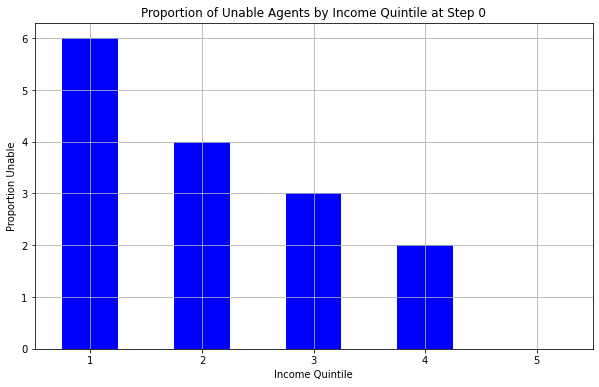

In [74]:
agent_data = model.datacollector.get_agent_vars_dataframe()
agent_data.reset_index(inplace=True)
agent_data_0 = agent_data[agent_data['Step'] == 0]  # agent data at step 0

# calculate quintiles of Income
quintiles = pd.qcut(agent_data_0['Income'], 5, labels=False) + 1
agent_data_0.loc[:, 'Income Quintile'] = quintiles

grouped = agent_data_0.groupby('Income Quintile')['Inability'].sum()

plt.figure(figsize=(10, 6))
grouped.plot(kind='bar', color='blue')
plt.xlabel('Income Quintile')
plt.ylabel('Proportion Unable')
plt.title('Proportion of Unable Agents by Income Quintile at Step 0')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

C:\Users\novak\AppData\Local\Temp\ipykernel_14872\3224168791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agent_data_0.loc[:, 'Income Quintile'] = quintiles


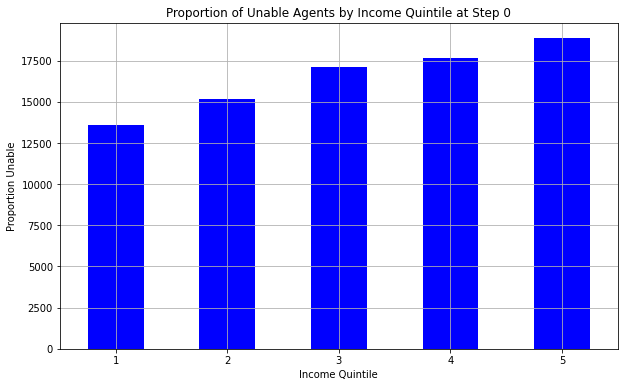

In [75]:
# calculate quintiles of Income
quintiles = pd.qcut(agent_data_0['Income'], 5, labels=False) + 1
agent_data_0.loc[:, 'Income Quintile'] = quintiles

grouped = agent_data_0.groupby('Income Quintile')['Dwelling'].sum()

plt.figure(figsize=(10, 6))
grouped.plot(kind='bar', color='blue')
plt.xlabel('Income Quintile')
plt.ylabel('Proportion Unable')
plt.title('Proportion of Unable Agents by Income Quintile at Step 0')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

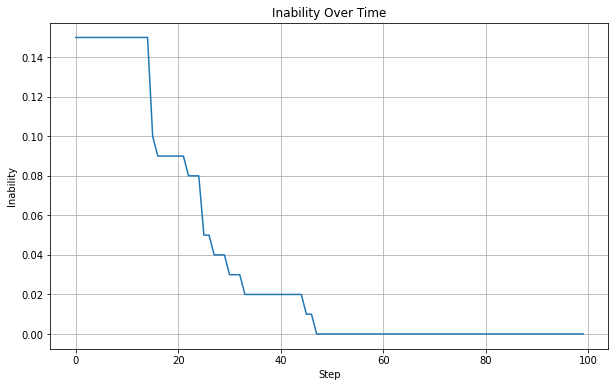

In [76]:
# After running the model
model_data = model.datacollector.get_model_vars_dataframe()

plt.figure(figsize=(10, 6))
plt.plot(model_data['Inability Over Time'])
plt.xlabel('Step')
plt.ylabel('Inability')
plt.title('Inability Over Time')
plt.grid(True)
plt.show()

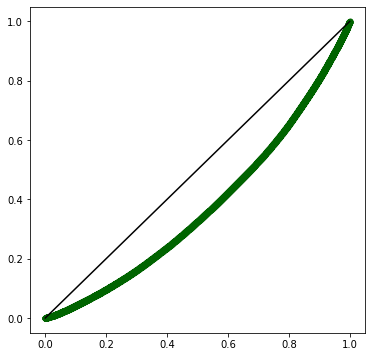

In [77]:
def plot_lorenz_curve(X, yummy_figs = (6, 6)):

    X_sorted = np.sort(X)  # Sort the incomes
    lorenz = np.cumsum(X_sorted) / np.sum(X_sorted)
    lorenz = np.insert(lorenz, 0, 0)
    lorenz[0], lorenz[-1]

    fig, ax = plt.subplots(figsize=[yummy_figs[0],yummy_figs[1]])
    ax.scatter(np.arange(lorenz.size)/(lorenz.size-1), lorenz, 
            marker='.', color='darkgreen', s=100)
    ## line plot of equality
    ax.plot([0,1], [0,1], color='k')

plot_lorenz_curve(agent_data["Income"])

In [78]:
agent_data.tail(100)

,Step,AgentID,Dwelling,Income,Inability,Savings,EnergyCost
9900,99,22,400,500.000000,False,46641.675306,20.178113
9901,99,48,400,585.389119,False,55095.198062,20.178113
9902,99,73,402,603.803890,False,56903.968748,20.279003
9903,99,98,401,764.264557,False,72796.720639,20.228558
9904,99,97,472,786.624877,False,74503.039703,23.810173
...,...,...,...,...,...,...,...
9995,99,55,1159,3421.308160,False,330427.512039,58.466082
9996,99,66,1384,3588.061863,False,345328.320972,69.816271
9997,99,10,499,3678.273806,False,360583.346723,25.172196
9998,99,86,906,3835.221501,False,373212.823141,45.703426


In [79]:
model_data = model.datacollector.get_model_vars_dataframe()